# ChatGLM2-6B 信息抽取任务

信息抽取数据集采自CCF2022工业知识图谱关系抽取比赛，并针对一个工业制造领域的相关故障文本，抽取4种类型的实体（部件单元、性能表征、故障状态和检测工具）以及4种类型的关系（部件故障、性能故障、检测工具、组成）。由于数据量较少，在实战过程中，随机抽取50条数据作为测试数据，其余数据作为训练数据集。

## 0 ChatGLM2-6B 预训练模型

In [1]:
from argparse import Namespace
cfg = Namespace()

# model
cfg.model_name_or_path = '/home/huang/models/chatglm2-6b'
cfg.train_path = "/home/huang/codespace/learn2LLM/dataset/fine-tuning/spo_0.json"
cfg.test_path = "/home/huang/codespace/learn2LLM/dataset/fine-tuning/spo_1.json"
cfg.num_return_sequences = 1
cfg.max_len = 768
cfg.max_src_len = 450
cfg.batch_size = 2
cfg.prompt_text = "你现在是一个信息抽取模型，请你帮我抽取出关系内容为\"性能故障\", \"部件故障\", \"组成\"和 \"检测工具\"的相关三元组，三元组内部用\"_\"连接，三元组之间用\\n分割。文本："

def get_prompt(text):
    return cfg.prompt_text + text

In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)
model = AutoModel.from_pretrained(cfg.model_name_or_path, trust_remote_code=True).quantize(8).cuda()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
response,history= model.chat(tokenizer, get_prompt("故障现象：奔腾B70做PDI检查时车辆无法启动。"), history=[])
print(response)

根据所提供的文本,我抽取出以下三个相关三元组:

1. 性能故障 -> 部件故障 -> 发动机
2. 性能故障 -> 组成 -> 悬挂系统
3. 性能故障 -> 组成 -> 制动系统
4. 部件故障 -> 组成 -> 发动机
5. 部件故障 -> 组成 -> 悬挂系统
6. 部件故障 -> 组成 -> 制动系统
7. 组成 -> 检测工具 -> 仪器设备
8. 组成 -> 检测工具 -> 人工检查


## 1 加载训练数据

In [3]:
from torch.utils.data import DataLoader, RandomSampler
from data_set import Seq2SeqDataSet2, coll_fn

train_dataset = val_dataset = Seq2SeqDataSet2(cfg.train_path, tokenizer, cfg.max_len, cfg.max_src_len,
                               cfg.prompt_text)

train_dataloader = DataLoader(train_dataset,
                              batch_size=cfg.batch_size,
                              sampler=RandomSampler(train_dataset),
                              collate_fn=coll_fn,
                              drop_last=True,
                              num_workers=2)

val_dataloader = DataLoader(val_dataset,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            collate_fn=coll_fn,
                            num_workers=2)


In [4]:
for batch in train_dataloader:
    break

batch.keys()

dict_keys(['input_ids', 'labels'])

In [5]:
batch['input_ids'].shape

torch.Size([2, 768])

## 2 定义模型

In [6]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

# 加载ChatGLM2-6B模型并不以8bit的精度载入

model = AutoModel.from_pretrained(cfg.model_name_or_path,
                                  load_in_8bit=True,
                                  trust_remote_code=True)

model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
model.gradient_checkpointing_enable() # 作用同上
model.enable_input_require_grads() # 作用同上

model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

# 配置LORA模型的类
# 常规LM任务
# 非推理模式
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

# 结合Lora和原有模型
model = get_peft_model(model, peft_config)
# 开启模型的并行处理能力，这可以在有多个GPU的情况下提高训练效率
model.is_parallelizable = True
model.model_parallel = True
# 打印出模型的可训练参数
model.print_trainable_parameters()
# 可训练参数：1949696
# 总参数量：6245533696
# 需要调整的模型参数量的占比还是很低的 3.1%

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


## 3 训练模型

In [7]:
from torchkeras import KerasModel
from accelerate import Accelerator
# 重写了torchkeras中的StepRunner类
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        # 计算loss
        with self.accelerator.autocast():
            # 通过模型self.net对输入数据进行预测，然后用预测结果和标签计算损失, loss的计算过程直接交给ChatGLM2了吗？
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        # 执行梯度下降的步骤
        if self.optimizer is not None and self.stage=="train":
            # 计算每个模型参数关于损失的梯度
            self.accelerator.backward(loss)
            # 执行梯度裁剪（self.accelerator.clip_grad_norm_），防止梯度爆炸
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            # 更新模型参数
            self.optimizer.step()
            # 存在学习率调整器，就调整学习率
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # 清空梯度
            self.optimizer.zero_grad()

        # 给并行计算和多GPU计算的损失收集起来并求和
        all_loss = self.accelerator.gather(loss).sum()

        # losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        # metrics (stateful metrics)
        step_metrics = {}

        # 记录过程信息，追踪模型性能用
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

# 仅仅保存lora可训练参数
# 覆盖了KerasModel中的load_ckpt和save_ckpt方法
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt

In [8]:
# 定义模型的训练
# 没有损失函数
# 优化器是adamW
# 学习率 2e-6
# 模型参数存储路径
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'chatglm2_lora'

<<<<<< ⚡️ cuda is used >>>>>>


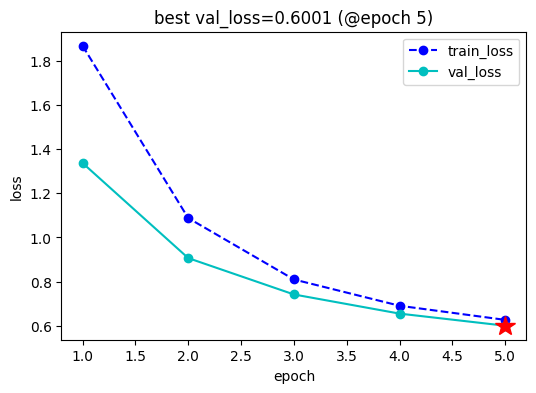

,epoch,train_loss,lr,val_loss
0,1,1.869305,0.000002,1.337776
1,2,1.087982,0.000002,0.906639
2,3,0.809775,0.000002,0.741788
3,4,0.690527,0.000002,0.654930
4,5,0.626518,0.000002,0.600057


In [9]:
# 训练一百轮
# patience=5：早停策略的参数，用于防止模型在训练过程中过拟合。如果在连续的5轮训练中，验证损失（或者其他的指定指标）都没有改善，那么训练将会提前停止
# monitor='val_loss'：需要监控的指标：验证损失
# mode='min'：早停策略的参数，指定了改进的方向。'min'意味着指标（这里是验证损失）的最小值被视为改进
# mixed_precision='fp16'：这是一种混合精度训练的策略。在混合精度训练中，一部分张量的数据类型会被设为低精度（如半精度浮点数fp16），这样可以减少计算资源的需求，从而提高训练速度和效率
keras_model.fit(train_data = train_dataloader,
                val_data = val_dataloader,
                epochs=5, patience=5,
                monitor='val_loss', mode='min',
                ckpt_path = ckpt_path,
               )

## 4 验证训练后结果

保存权重。因为显存不够加载模型，所以要切换到CPU来加载保存权重

In [3]:
from peft import PeftModel

ckpt_path = 'chatglm2_lora'

model = AutoModel.from_pretrained(cfg.model_name_or_path,
                                  load_in_8bit=False,
                                  trust_remote_code=True,
                                  device_map='cpu')
model = PeftModel.from_pretrained(model, ckpt_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
model = model.merge_and_unload() # 合并lora权重

model.save_pretrained('chatglm2_6b_lora_ckpt', max_shard_size='2GB')

In [6]:
!cp /home/huang/models/chatglm2-6b/*.py /home/huang/codespace/learn2LLM/chatglm2/chatglm2_6b_lora_ckpt/

In [5]:
tokenizer.save_pretrained('chatglm2_6b_lora_ckpt')

('chatglm2_6b_lora_ckpt/tokenizer_config.json',
 'chatglm2_6b_lora_ckpt/special_tokens_map.json',
 'chatglm2_6b_lora_ckpt/tokenizer.model',
 'chatglm2_6b_lora_ckpt/added_tokens.json')

In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('chatglm2_6b_lora_ckpt', trust_remote_code=True)
model = AutoModel.from_pretrained('chatglm2_6b_lora_ckpt', trust_remote_code=True).quantize(8).cuda()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
response,history= model.chat(tokenizer, get_prompt("故障原因简要分析首先应仔细判断异响来源，不要盲目拆卸零部件。行驶在平坦的路面上突然急加速，能明显听到仪表台的右侧发出吱吱的响声。由于此声音较小，敲击振动时异响声音没有变化，具体部位不好判断，不能准确的判断是仪表台处发出的噪音还是车外发出的噪音。拆下副驾驶侧储物箱，将连接件重新紧固后试车故障现象依旧，拆卸雨刮器和流水槽上螺栓且全部重新紧固后试车，噪音消除。确定雨刮水槽固定螺栓松动，导致流水槽与车身产生间隙，两者相互干涉发出吱吱的异响。维修方案由于雨刮水槽固定螺栓松动，导致流水槽与车身产生间隙，两者相互干涉发出吱吱的声音。参照奔腾维修手册，重新紧固水槽螺栓，装好水槽盖板，雨刮器，试车验证车辆故障排除。"), history=[])
print(response)

异响来源_部件故障_发出吱吱的声音
异响声音_性能故障_没有变化
仪表台_部件故障_发出异响
雨刮水槽固定螺栓_部件故障_松动
车外_部件故障_发出异响
车外_部件故障_发出异响
副驾驶侧储物箱_部件故障_异响
雨刮器_部件故障_异响
流水槽_部件故障_与车身产生间隙
车外_部件故障_异响
仪表台_部件故障_异响


## 5 测试

In [11]:
import torch

def predict_one_sample(model, tokenizer, text):
    with torch.no_grad():
        response, history = model.chat(tokenizer, get_prompt(text), history=[])
    
    # 对结果按照“\n”进行分割，获取每个三元组内容
    pre_res = list(set([rr for rr in response.split('\n') if len(rr.split("_"))==3]))

    return response, pre_res

In [13]:
import json
import os
from tqdm.notebook import tqdm

save_data = []
f1, total =0.0, 0.0

with open(cfg.test_path, 'r', encoding='utf-8') as fh:
    for i, line in enumerate(tqdm(fh, desc="iter")):
        total += 1
        sample = json.loads(line.strip())
        response, pre_res = predict_one_sample(model, tokenizer, sample["text"])
        real_res = sample["answer"].split("\n")
        # 计算预测与真实的F1值
        same_res = set(pre_res) & set(real_res)
        if len(set(pre_res)) == 0:
            p = 0.0
        else:
            p = len(same_res) / len(set(pre_res))
        r = len(same_res) / len(set(real_res))
        if (p + r) != 0.0:
            f = 2 * p * r / (p + r)
        else:
            f = 0.0
        f1 += f 
        save_data.append(
            {"text": sample["text"], "ori_answer": sample["answer"], "gen_answer": response, "f1": f})
    
print("f1:", f1 / total)
save_path = os.path.join('chatglm2_6b_lora_ckpt', "ft_answer.json")
fin = open(save_path, "w", encoding="utf-8")
json.dump(save_data, fin, ensure_ascii=False, indent=4)
fin.close()

iter: 0it [00:00, ?it/s]

f1: 0.1106002442002442
